In [1]:
# original code and data: https://www.kaggle.com/klev4n/train-lego-brick-classifier

import numpy as np
import pandas as pd
import os
import glob
from tqdm import tqdm
from random import shuffle

In [2]:
data_dir = ".\\archive\\dataset"
all_files = pd.Series(
    [fn.lstrip(f"{data_dir}\\") for fn in glob.glob(f"{data_dir}\\*.png")])

with open(".\\archive\\validation.txt", 'r') as f:
    val_files = pd.Series([fn.strip() for fn in f.readlines()])
train_files = all_files[~all_files.isin(val_files)]

train_files = train_files.sample(frac=1)
val_files = val_files.sample(frac=1)

def filename_to_label(file_path):
    filename = file_path.split(os.path.sep)[-1]
    parts = filename.replace(".png", "").split(" ")[:-1]
    return "".join(parts)

train_files = [f"{data_dir}\\{f}" for f in train_files]
train_labels = [filename_to_label(f) for f in train_files]
val_files = [f"{data_dir}\\{f}" for f in val_files]
val_labels = [filename_to_label(f) for f in val_files]


len(train_files), len(val_files)

(32000, 8000)

In [3]:
train_files[0:3], train_labels[0:3], val_files[0:3], val_labels[0:3]

(['.\\archive\\dataset\\18654 beam 1M 226L.png',
  '.\\archive\\dataset\\3005 brick 1x1 370L.png',
  '.\\archive\\dataset\\3069 Flat Tile 1x2 249R.png'],
 ['18654beam1M', '3005brick1x1', '3069FlatTile1x2'],
 ['.\\archive\\dataset\\41677 lever 2M 029R.png',
  '.\\archive\\dataset\\2780 Peg with friction 013R.png',
  '.\\archive\\dataset\\3623 Plate 1x3 018L.png'],
 ['41677lever2M', '2780Pegwithfriction', '3623Plate1x3'])

In [4]:
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


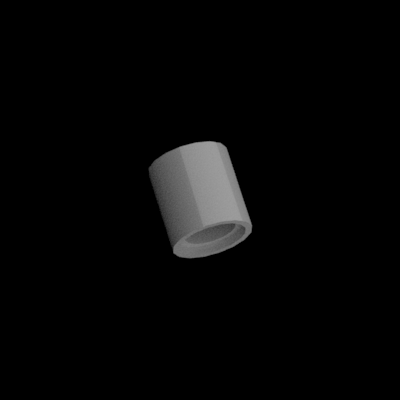

In [5]:
PIL.Image.open(train_files[0])

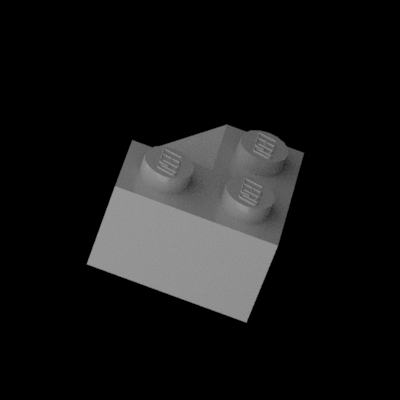

In [6]:
PIL.Image.open(val_files[1337])

In [7]:
tf.convert_to_tensor(list(set(train_labels)))

<tf.Tensor: shape=(50,), dtype=string, numpy=
array([b'3298rooftile2x3', b'6143BrickD16wcross', b'2780Pegwithfriction',
       b'3675rooftileoutside3x3', b'3700TechnicBrick1x2',
       b'4490brickbow1x3', b'33909plate2knobs2x2',
       b'27925flattileround2x2', b'3659brickbow1x4', b'3001brick2x4',
       b'14719flattilecorner2x2', b'85984rooftile1x2', b'43857beam1x2',
       b'3024plate1x1', b'3046roofcornerinsidetile2x2',
       b'4286rooftile1x3', b'3004brick1x2', b'3623Plate1x3',
       b'3005brick1x1', b'3023Plate1x2', b'54200rooftile1x1',
       b'41677lever2M', b'2357brickcorner1x2x2', b'3069FlatTile1x2',
       b'3003brick2x2', b'15672rooftile1x2', b'3010brick1x4',
       b'3021plate2x3', b'3039rooftile2x2', b'18654beam1M',
       b'4274ConnectorPegwKnob', b'3040rooftile1x2', b'3070FlatTile1x1',
       b'3002brick2x3', b'3022Plate2x2', b'2420platecorner2x2',
       b'3063CurvedBrick2Knobs', b'99301rooftileinside3x3',
       b'3037rooftile1x4', b'3020plate2x4', b'41678CrossBlockF

In [8]:
class_names = tf.convert_to_tensor(list(set(train_labels)))


def get_label(file_path, class_names):
    filename = tf.strings.split(file_path, os.path.sep)[-1]
    parts = tf.strings.split(tf.strings.regex_replace(filename, ".png", ""), " ")[:-1]
    label = tf.strings.reduce_join(parts)

    one_hot = label == class_names
    return tf.argmax(one_hot)

def decode_img(img, img_height, img_width):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path, img_height=128, img_width=128):
    label = get_label(file_path, class_names)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img, img_height, img_width)
    return img , label

# get_label(test_files[1337], class_names)
img, lb = process_path(train_files[0])
# img.shape, lb

In [9]:
train = (
    tf.data.Dataset
    .from_tensor_slices(train_files)
    .map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
)
    

val = (
    tf.data.Dataset
    .from_tensor_slices(val_files)
    .map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
)

In [10]:
for images, labels in val.shuffle(10).take(4):
    print("Image shape: ", images.numpy().shape)
    print("Label: ", labels.numpy())

Image shape:  (128, 128, 3)
Label:  21
Image shape:  (128, 128, 3)
Label:  12
Image shape:  (128, 128, 3)
Label:  29
Image shape:  (128, 128, 3)
Label:  2


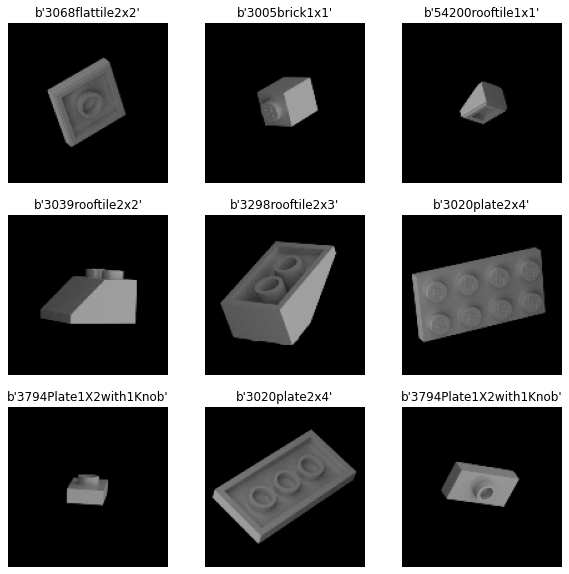

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
i = 0
for images, labels in train.shuffle(50).take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(class_names[labels].numpy())
    plt.axis("off")
    i = i + 1

In [12]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 128, 3)
()


In [13]:
batch_size = 128
train_ds = train.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
img_height, img_width = (128, 128)
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0

In [18]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
250/250 [==============================] - 4s 15ms/step - loss: 0.3343 - accuracy: 0.8872 - val_loss: 1.3659 - val_accuracy: 0.6660
Epoch 2/50
250/250 [==============================] - 4s 15ms/step - loss: 0.2792 - accuracy: 0.9044 - val_loss: 1.3779 - val_accuracy: 0.6779
Epoch 3/50
250/250 [==============================] - 4s 15ms/step - loss: 0.2423 - accuracy: 0.9154 - val_loss: 1.5097 - val_accuracy: 0.6600
Epoch 4/50
250/250 [==============================] - 4s 15ms/step - loss: 0.2252 - accuracy: 0.9228 - val_loss: 1.5638 - val_accuracy: 0.6669
Epoch 5/50
250/250 [==============================] - 4s 15ms/step - loss: 0.1984 - accuracy: 0.9302 - val_loss: 1.5575 - val_accuracy: 0.6775
Epoch 6/50
250/250 [==============================] - 4s 15ms/step - loss: 0.1678 - accuracy: 0.9421 - val_loss: 1.6213 - val_accuracy: 0.6791
Epoch 7/50
250/250 [==============================] - 4s 16ms/step - loss: 0.1564 - accuracy: 0.9462 - val_loss: 1.7410 - val_accuracy: 0.6759

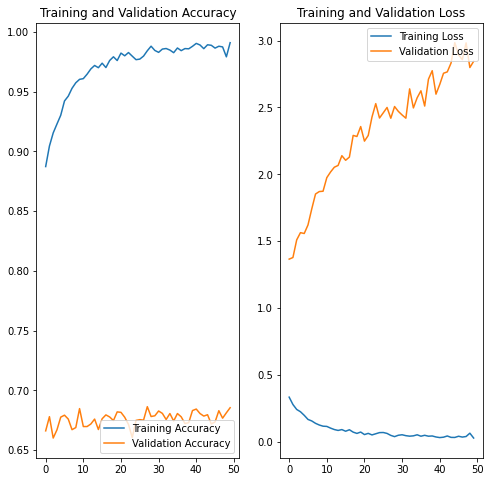

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
def do_predict(predict_file):
    predict_img, predict_label = process_path(predict_file)
    class_probabilities = model.predict(np.array([predict_img]))
    most_likely = np.argmax(class_probabilities)
    return predict_img, class_names[predict_label].numpy(), class_names[most_likely].numpy()
    
predict_file = val_files[100]
_, _, predict_label = do_predict(predict_file)
predict_label

b'3068flattile2x2'

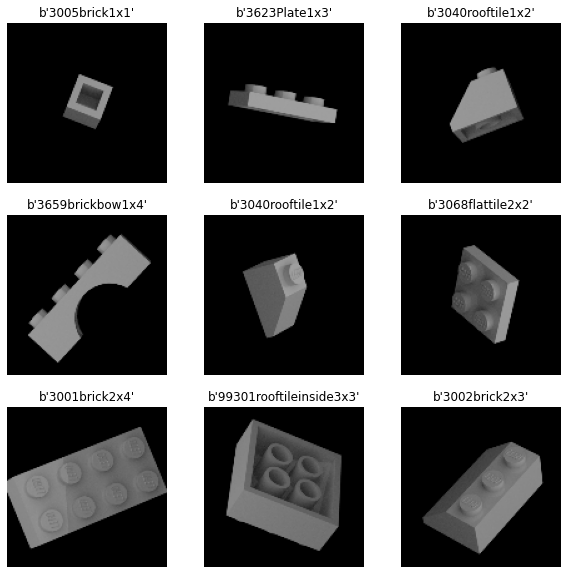

In [64]:
import random
plt.figure(figsize=(10, 10))
i = 0
for val_file in random.sample(val_files, 9):
    img, correct_label, predicted_label = do_predict(val_file)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(predicted_label)
    plt.axis("off")
    i = i + 1